QBIO-482 Final Project Code: A Simplified Model of the *Drosophila* Circadian Oscillator (*PER & dCLOCK*)


---

Authors: Angela Bai and Kiley Huffman




**Equation 1:**

*   *dCLOCK* is constant in total
*   Feedback is captured via a Hill-like regulation function.

This equation describes how *PER* is synthesized and degraded over time.

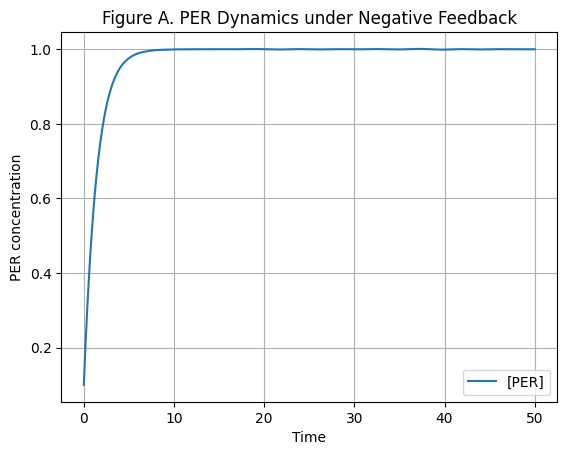

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
vs = 1.0           # Max synthesis rate of PER
kd_p = 0.5         # Degradation rate of PER
K1 = 1.0           # Activation constant
dCLOCK_total = 2.0 # Total dCLOCK concentration (assumed constant)

# ODE system for d[PER]/dt
def per_ode(t, PER):
    dCLOCK_free = dCLOCK_total - PER
    RsP = dCLOCK_free / (K1 + dCLOCK_free)
    dPER_dt = vs * RsP - kd_p * PER
    return dPER_dt

# Time span and initial condition
t_span = (0, 50)
t_eval = np.linspace(*t_span, 1000)
PER0 = [0.1]

# Solve ODE
sol = solve_ivp(per_ode, t_span, PER0, t_eval=t_eval)

# Plotting
plt.plot(sol.t, sol.y[0], label='[PER]')
plt.xlabel('Time')
plt.ylabel('PER concentration')
plt.title('Figure A. PER Dynamics under Negative Feedback')
plt.grid(True)
plt.legend()
plt.show()

Equation 2:

This is a Michaelis-Menten or Hill-type activation function that describes how the synthesis rate of *PER* depends on the amount of free *dCLOCK*. As more *dCLOCK* is available, *PER* synthesis increases but saturates at high concentrations.

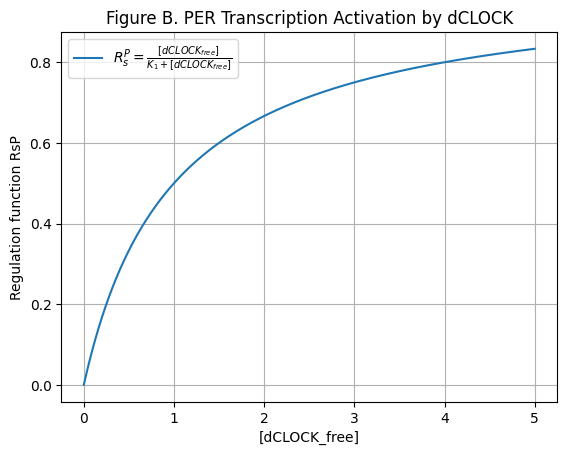

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
K1 = 1.0  # Activation constant

# Range of free dCLOCK values
dCLOCK_free = np.linspace(0, 5, 500)

# Regulation function RsP
RsP = dCLOCK_free / (K1 + dCLOCK_free)

# Plotting
plt.plot(dCLOCK_free, RsP, label=r'$R_s^P = \frac{[dCLOCK_{free}]}{K_1 + [dCLOCK_{free}]}$')
plt.xlabel('[dCLOCK_free]')
plt.ylabel('Regulation function RsP')
plt.title('Figure B. PER Transcription Activation by dCLOCK')
plt.grid(True)
plt.legend()
plt.show()

**Equation 3:** This equation captures the sequestration mechanism: as *PER *increases, it binds *dCLOCK*, reducing the amount of free *dCLOCK* available to drive transcription.

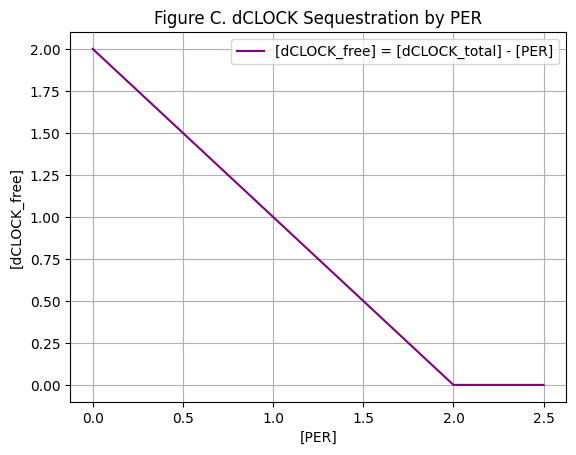

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Total dCLOCK concentration
dCLOCK_total = 2.0

# Range of PER values
PER = np.linspace(0, 2.5, 500)

# dCLOCK_free calculation
dCLOCK_free = dCLOCK_total - PER

# Ensure no negative concentrations
dCLOCK_free[dCLOCK_free < 0] = 0

# Plotting
plt.plot(PER, dCLOCK_free, label=r'[dCLOCK_free] = [dCLOCK_total] - [PER]', color='purple')
plt.xlabel('[PER]')
plt.ylabel('[dCLOCK_free]')
plt.title('Figure C. dCLOCK Sequestration by PER')
plt.grid(True)
plt.legend()
plt.show()

## **ODE Model of the Simplified PER/dCLOCK Feedback Loop** (Combines Equations 1, 2, and 3)


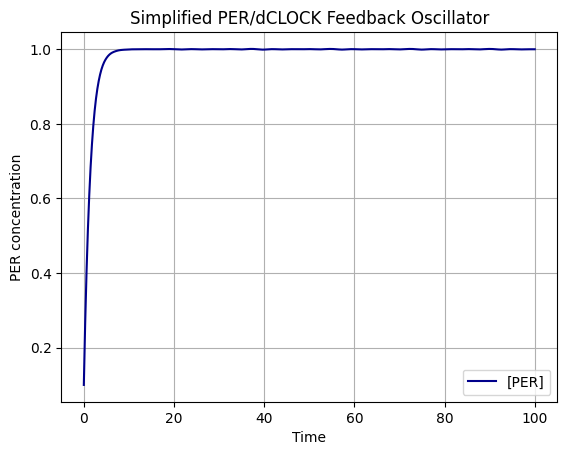

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
vs = 1.0            # Max synthesis rate of PER
kd_p = 0.5          # Degradation rate of PER
K1 = 1.0            # Michaelis-Menten constant
dCLOCK_total = 2.0  # Total dCLOCK (assumed constant)

# ODE system for d[PER]/dt using all three equations
def feedback_model(t, y):
    PER = y[0]

    # Equation 3: Free dCLOCK
    dCLOCK_free = dCLOCK_total - PER
    dCLOCK_free = max(dCLOCK_free, 0)  # Avoid negative values

    # Equation 2: Regulation function RsP
    RsP = dCLOCK_free / (K1 + dCLOCK_free)

    # Equation 1: PER dynamics
    dPER_dt = vs * RsP - kd_p * PER

    return [dPER_dt]

# Initial condition and time span
PER0 = [0.1]
t_span = (0, 100)
t_eval = np.linspace(*t_span, 1000)

# Solve the system
sol = solve_ivp(feedback_model, t_span, PER0, t_eval=t_eval)

# Plot result
plt.plot(sol.t, sol.y[0], label='[PER]', color='darkblue')
plt.xlabel('Time')
plt.ylabel('PER concentration')
plt.title('Simplified PER/dCLOCK Feedback Oscillator')
plt.grid(True)
plt.legend()
plt.show()


# **MAIN MODEL:** behavior of the *Drosophila* Circadian Oscillator Under Different Conditions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


#PARAMETERS
vsP = 0.5     #Max PER synthesis rate, normalized to 1 for simplicity
kdP = 0.5     #PER degradation rate, consistent with paper, corresponds to a protein half-life of ~3.5 hours, reasonable for circadian proteins
K1 = 0.3      #Activation constant for PER synthesis, values chosen to be just below typical [dCLOCK] range, allowing for oscillations

vsC = 0.25     #Max dCLOCK synthesis rate
kdC = 0.5     #dCLOCK degradation rate
K2 = 0.1      #Repression constant for dCLOCK synthesis

tau1 = 10.0   #Delay for PER production [baseline], matches delays used in paper
tau2 = 10.0   #Delay for dCLOCK repression

#TIME
tmax = 120    #In hours, so 5 days total
dt = 0.1
t = np.arange(0, tmax, dt)


#INITIAL CONDITIONS
PER0 = 0.1    #Non-zero to avoid trivial steady-state solutions, and using small values reflects low baseline expression
CLOCK0 = 0.1


#DELAY HANDLER
#Odeint doesn't handle time delays, so this function finds the values of PER and dCLOCK from an earlier time ex: “What were the values of PER and dCLOCK τ hours ago?”
def get_delayed(y_vals, t_vals, current_t, delay):
    if current_t - delay <= 0:
        return [PER0, CLOCK0]
    idx = np.where(t_vals >= current_t - delay)[0][0]
    return y_vals[idx]


#MATHEMATICAL MODEL
#Our system of ODEs
#Calculates the rate of change of PER and dCLOCK at time t, including effects of time delays

def model_full(y, t, t_vals, y_vals, tau1, tau2, pos_feedback=True):
    PER, CLOCK = y

    #Get the values of PER and dCLOCK from tau1 hours ago (for PER regulation)
    PER_tau1 = get_delayed(y_vals, t_vals, t, tau1)
    CLOCK_tau1 = get_delayed(y_vals, t_vals, t, tau1)
    CLOCK_tau2 = get_delayed(y_vals, t_vals, t, tau2)

    #Get specific concentrations from delayed arrays
    PER_val = PER_tau1[0] #PER concentration at t - tau1
    CLOCK_val_tau1 = CLOCK_tau1[1] #The dCLOCK concentration at t - tau1 (used to compute free dCLOCK for PER regulation)
    CLOCK_val_tau2 = CLOCK_tau2[1] #The dCLOCK concentration at t - tau2 (used for dCLOCK's self-repression)

    #The amount of free (unbound) dCLOCK at t - tau1 and t - tau2
    CLOCK_free_tau1 = max(CLOCK_val_tau1 - PER_val, 0)
    CLOCK_free_tau2 = max(CLOCK_val_tau2 - PER_val, 0)

    #Regulation functions
    RsP = CLOCK_free_tau1 / (K1 + CLOCK_free_tau1) #How strongly PER is being produced, based on free dCLOCK from t - tau1
    RsC = (K2 / (K2 + CLOCK_free_tau2)) if pos_feedback else 1.0 #How strongly dCLOCK is being synthesized (based on its own repression)

    #Differential equations
    dPER_dt = vsP * RsP - kdP * PER #Equation 1
    dCLOCK_dt = vsC * RsC - kdC * CLOCK #Equation 4

    return [dPER_dt, dCLOCK_dt]


#SIMULATION
#Solves the ODE model's equations over time range "t" with scipy's ODEINT

def simulate_ode_model(t, tau1, pos_feedback=True):
    y0 = [PER0, CLOCK0] #Initial conditions
    y_vals = np.zeros((len(t), 2)) #2D array to store PER and dCLOCK values at each time step
    y_vals[0] = y0 #Setting first row to our initial conditions

    #Loop to integrate model step-by-step because we are using time delays, which most ODE solvers don't support directly
    for i in range(1, len(t)):
        sol = odeint(model_full, y_vals[i-1], [t[i-1], t[i]],
                     args=(t[:i], y_vals[:i], tau1, tau2, pos_feedback))
        y_vals[i] = sol[-1]

    return y_vals #Returns the results over time, one row per time point, two columns (PER and dCLOCK)

# **FIGURE 1.** Baseline Oscillations OF *PER* and *dCLOCK*

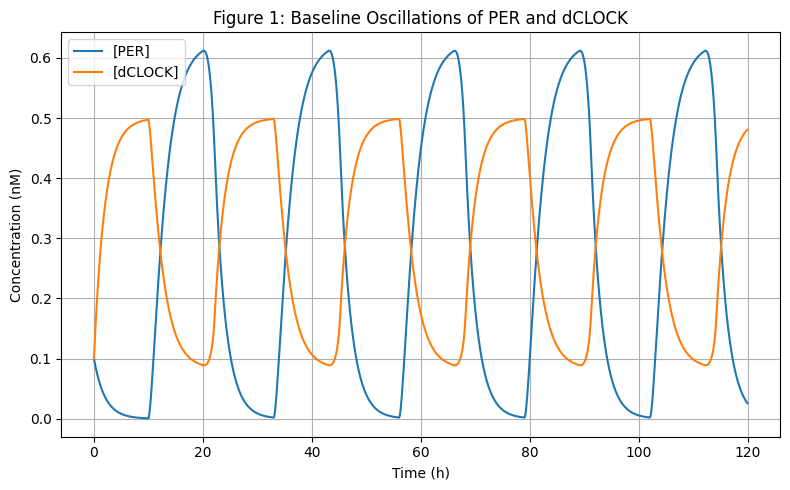

In [ ]:
#FIGURE 1: Baseline Oscillations
baseline = simulate_ode_model(t, tau1)
plt.figure(figsize=(8,5))
plt.plot(t, baseline[:, 0], label='[PER]')
plt.plot(t, baseline[:, 1], label='[dCLOCK]')
plt.xlabel('Time (h)')
plt.ylabel('Concentration (nM)')
plt.title('Figure 1: Baseline Oscillations of PER and dCLOCK')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **FIGURE 2.** Sensitivity of Oscillations to Delay T1

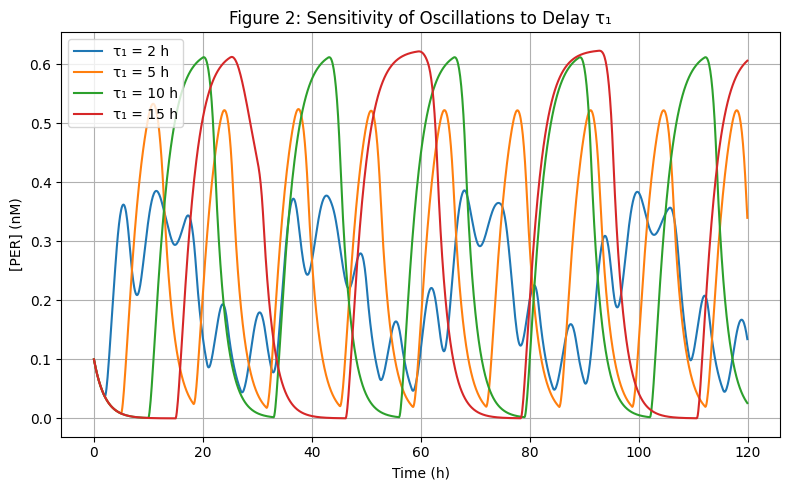

In [ ]:
#FIGURE 2: Parameter Sensitivity to tau1
plt.figure(figsize=(8,5))
for tau1_var in [2, 5, 10, 15]:
    sim = simulate_ode_model(t, tau1=tau1_var)
    plt.plot(t, sim[:,0], label=f'τ₁ = {tau1_var} h')

plt.xlabel('Time (h)')
plt.ylabel('[PER] (nM)')
plt.title('Figure 2: Sensitivity of Oscillations to Delay τ₁')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **FIGURE 3.** Effect of Positive Feedback on PER Oscillations

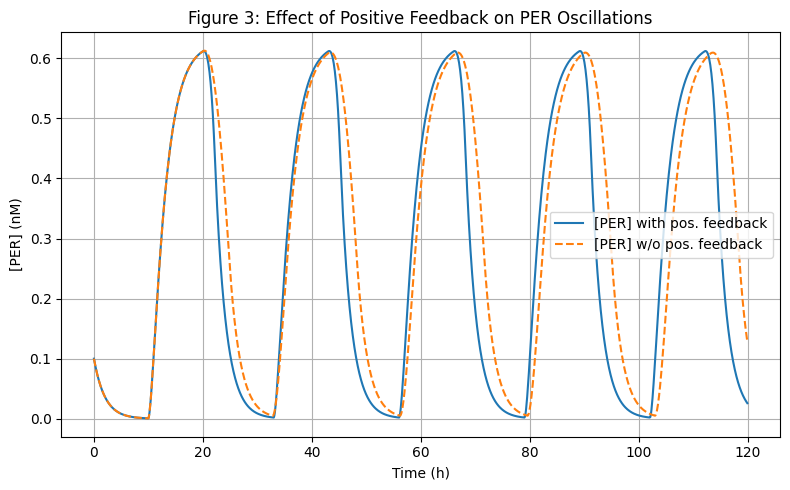

In [ ]:
#FIGURE 3: With vs Without Positive Feedback Loop
with_feedback = simulate_ode_model(t, tau1, pos_feedback=True)
no_feedback = simulate_ode_model(t, tau1, pos_feedback=False)

plt.figure(figsize=(8,5))
plt.plot(t, with_feedback[:,0], label='[PER] with pos. feedback', linestyle='-')
plt.plot(t, no_feedback[:,0], label='[PER] w/o pos. feedback', linestyle='--')
plt.xlabel('Time (h)')
plt.ylabel('[PER] (nM)')
plt.title('Figure 3: Effect of Positive Feedback on PER Oscillations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **FIGURE 4.** Effect of Noise Strength on PER and dCLOCK Oscillations

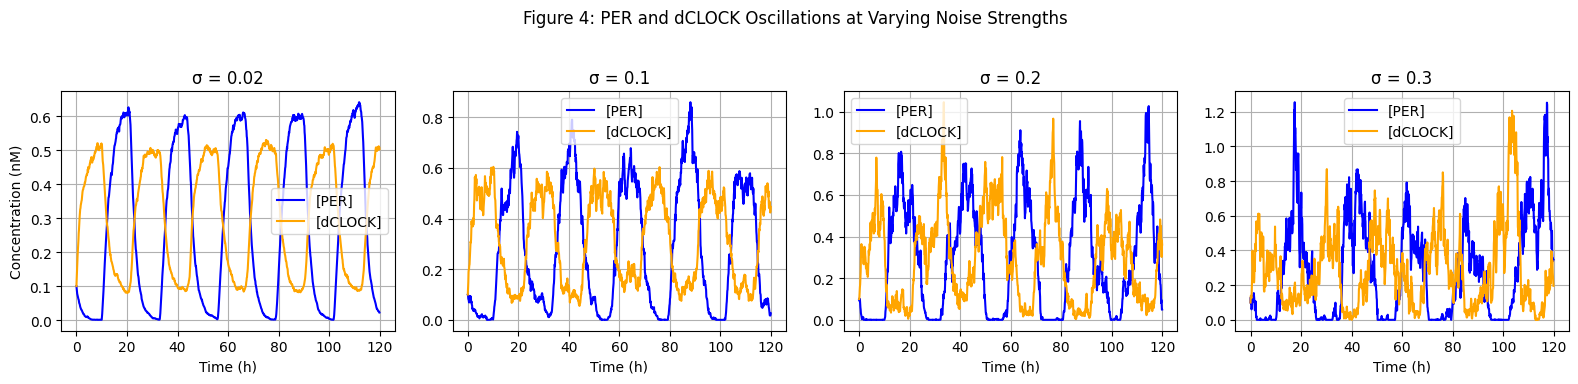

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#PARAMETERS (Identical to ODE Model)
vsP = 0.5
kdP = 0.5
K1 = 0.3

vsC = 0.25
kdC = 0.5
K2 = 0.1

tau1 = 10.0
tau2 = 10.0

#TIME
tmax = 120
dt = 0.1
t = np.arange(0, tmax, dt)

#INITIAL CONDITIONS
PER0 = 0.1
CLOCK0 = 0.1

#DELAY HANDLER
#Odeint doesn't handle time delays, so this function finds the values of PER and dCLOCK from an earlier time ex: “What were the values of PER and dCLOCK τ hours ago?”
def get_delayed(y_vals, t_vals, current_t, delay):
    if current_t - delay <= 0:
        return [PER0, CLOCK0]
    idx = np.where(t_vals >= current_t - delay)[0][0]
    return y_vals[idx]


#SIMULATION
#Incorporates multiplicative noise via the Euler-Maruyama method to capture biological variability
def simulate_sde_model(t, tau1, tau2, sigma_P, sigma_C, pos_feedback=True):
    y_vals = np.zeros((len(t), 2))
    y_vals[0] = [PER0, CLOCK0]

    for i in range(1, len(t)):
        current_t = t[i]
        dt_step = t[i] - t[i - 1]
        PER, CLOCK = y_vals[i - 1]

        #Delayed values
        PER_tau1 = get_delayed(y_vals, t[:i], current_t, tau1)
        CLOCK_tau1 = get_delayed(y_vals, t[:i], current_t, tau1)
        CLOCK_tau2 = get_delayed(y_vals, t[:i], current_t, tau2)

        PER_del = PER_tau1[0]
        CLOCK_del1 = CLOCK_tau1[1]
        CLOCK_del2 = CLOCK_tau2[1]

        CLOCK_free1 = max(CLOCK_del1 - PER_del, 0)
        CLOCK_free2 = max(CLOCK_del2 - PER_del, 0)

        RsP = CLOCK_free1 / (K1 + CLOCK_free1)
        RsC = (K2 / (K2 + CLOCK_free2)) if pos_feedback else 1.0

        # Drift (deterministic)
        dPER_det = vsP * RsP - kdP * PER
        dCLOCK_det = vsC * RsC - kdC * CLOCK

        #Stochastic noise
        dPER_stoch = sigma_P * np.sqrt(max(PER, 1e-6)) * np.random.normal(0, np.sqrt(dt_step))
        dCLOCK_stoch = sigma_C * np.sqrt(max(CLOCK, 1e-6)) * np.random.normal(0, np.sqrt(dt_step))

        #Euler-Maruyama updates
        PER_new = PER + dPER_det * dt_step + dPER_stoch
        CLOCK_new = CLOCK + dCLOCK_det * dt_step + dCLOCK_stoch

        #Prevents negative concentrations
        y_vals[i] = [max(PER_new, 0), max(CLOCK_new, 0)]

    return y_vals

#NOISE LEVELS TO TEST
noise_levels = [0.02, 0.1, 0.2, 0.3]

#PLOTTING
plt.figure(figsize=(16, 4))

for i, sigma in enumerate(noise_levels):
    result = simulate_sde_model(t, tau1, tau2, sigma, sigma)
    plt.subplot(1, len(noise_levels), i+1)
    plt.plot(t, result[:, 0], label='[PER]', color='blue')
    plt.plot(t, result[:, 1], label='[dCLOCK]', color='orange')
    plt.title(f'σ = {sigma}')
    plt.xlabel('Time (h)')
    if i == 0:
        plt.ylabel('Concentration (nM)')
    plt.grid(True)
    plt.legend()

plt.suptitle("Figure 4: PER and dCLOCK Oscillations at Varying Noise Strengths")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
